In [1]:
import sys
sys.path.append('..')

import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline 

from filters import KalmanFilter
from smoothers import KalmanSmoother

_reseed = True

# Kalman Filter Demo

The Kalman filter seeks to estimate a system given a state space model with linear-discrete process and observation models

$x_{t+1} = \mathbf{F}x_t + \mathbf{U}_fu^{(f)}_t + \mathbf{\xi}_t$

$y_t = \mathbf{H}x_t + \mathbf{U}_hu^{(h)}_t + \mathbf{\nu}_t$

with Gaussian noise with zero mean and known covariance, $\xi_t \sim \mathcal{N}(\mathbf{0},\mathbf{Q}_t)$ and $\nu_t \sim \mathcal{N}(\mathbf{0}, \mathbf{R}_t)$


## 1-D Example
For example, basic accelerated velocity model in 1 dimension

$x_t = [x, \dot{x}, \ddot{x}]^\text{T}$ and $y_t = [x]$

The respective process and observation functions are thus setup as 

$\mathbf{F} = \begin{bmatrix} 1 & 1 & 0 \\ 0 & 1 & 1 \\ 0 & 0 & 1\end{bmatrix} \qquad \mathbf{H} = \begin{bmatrix} 1 & 0 & 0 \end{bmatrix}$

The input control is not used, so $\mathbf{U}_f = \mathbf{U}_h = \mathbf{0}$

In [2]:
# Process model
F = np.array([[1, 1, 0], [0, 1, 1], [0, 0, 1]])
# H
H = np.array([[1, 0, 0]])

An example system can be setup, with the initial position at $x=0$, and the velocity and acceleration parameters set to $0.1$ and $0.05$ respectively. Noise for the process and observation is incorporated using setups for covariances for the noise terms.

In [3]:
# Process noise covariance
Q = np.diag(np.array([0., 0.01, 0.001]))

# Observation noise covariance
R = np.array([[400]])

# Initial state and estimation error covariance (assume Q)
x0 = np.array([[0., 0.1, 0.05]]).T
P0 = np.diag(np.array([10, 1, 0.1])) #Q.copy()

# Data dimensions
n_x = 3
n_y = 1

Model the systems

1499211700


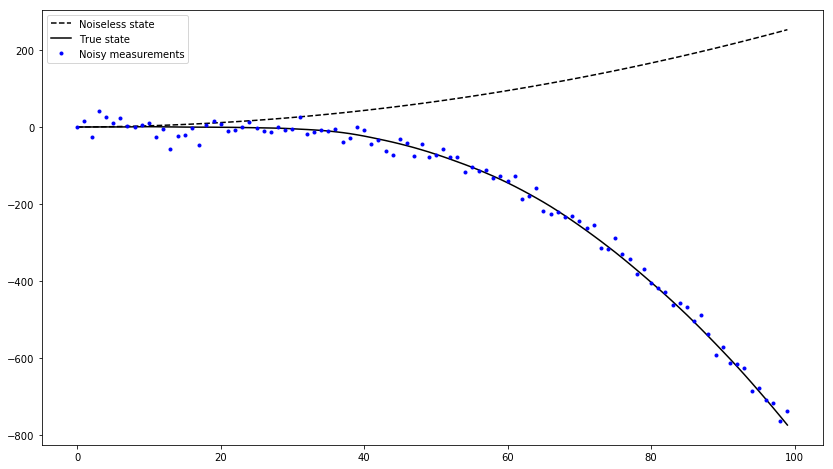

In [4]:
# Number of observations
n_t = 100
if _reseed:
    seed = np.random.randint(0,np.iinfo(np.int32).max)
    print(seed)
else:
    seed = 23927523
np.random.seed(seed)

# First model a perfect system
def sys_noiseless(x0, F, Q, H, R):
    n_x = x0.shape[0]
    
    x_noiseless = np.zeros((n_x, n_t))
    y_noiseless = np.zeros((R.shape[0], n_t))

    x_noiseless[:,0] = x0.ravel()
    y_noiseless[:,0] = (H @ x0).ravel()

    for i_ in range(1,n_t):
        x_noiseless[:,i_] = (F @ x_noiseless[:,i_-1].reshape(n_x,1)).ravel()
        y_noiseless[:,i_] = (H @ x_noiseless[:,i_].reshape(n_x,1)).ravel()

    return x_noiseless, y_noiseless

x_noiseless, y_noiseless = sys_noiseless(x0, F, Q, H, R)

# A noisy system
def sys_noisy(x0, F, Q, H, R):
    """ Noisy system modelling"""
    n_x = x0.shape[0]
    n_y = R.shape[0]
    
    x_true  = np.zeros((n_x, n_t))
    y_true  = np.zeros((n_y, n_t))
    y_noisy = np.zeros((n_y, n_t))

    x_true[:,0] = x0.ravel()
    y_true[:,0] = (H @ x0).ravel()
    y_noisy[:,0] = (H @ x0).ravel() # no noise for first

    for i_ in range(1,n_t):
        x_true[:,i_] = (F @ x_true[:,i_-1].reshape(n_x,1) + np.sqrt(Q) @ np.random.randn(n_x,1)).ravel()
        y_true[:,i_] = (H @ x_true[:,i_].reshape(n_x,1)).ravel()
        y_noisy[:,i_] = (H @ x_true[:,i_].reshape(n_x,1) + np.sqrt(R) @ np.random.randn(n_y,1)).ravel()
    
    return x_true, y_true, y_noisy

#
x_true, y_true, y_noisy = sys_noisy(x0, F, Q, H, R)


plt.figure(figsize=(14, 8))

plt.plot(y_noiseless.T, 'k--')
plt.plot(y_true.T, 'k-')
plt.plot(y_noisy.T,'b.')

plt.legend(labels=['Noiseless state', 'True state', 'Noisy measurements'])

In [5]:
kf = KalmanFilter(x0, P0, F, Q, H, R, _verbose=False)

x_estimate = np.zeros_like(x_true)
P_estimate = np.zeros((n_x, n_x, n_t))
y_estimate = np.zeros_like(y_true)

x_estimate[:,0] = x0.ravel()
y_estimate[:,0] = (H @ x0).ravel()
P_estimate[:,:,0] = P0

for i_ in range(1, n_t):
    kf.predict()
    kf.update(y_noisy[:,i_])
    x_estimate[:,i_] = kf.state['expected'].ravel()
    P_estimate[:,:,i_] = kf.state['err_cov']
    y_estimate[:,i_] = (H @ x_estimate[:,i_].reshape(n_x,1)).ravel()
    

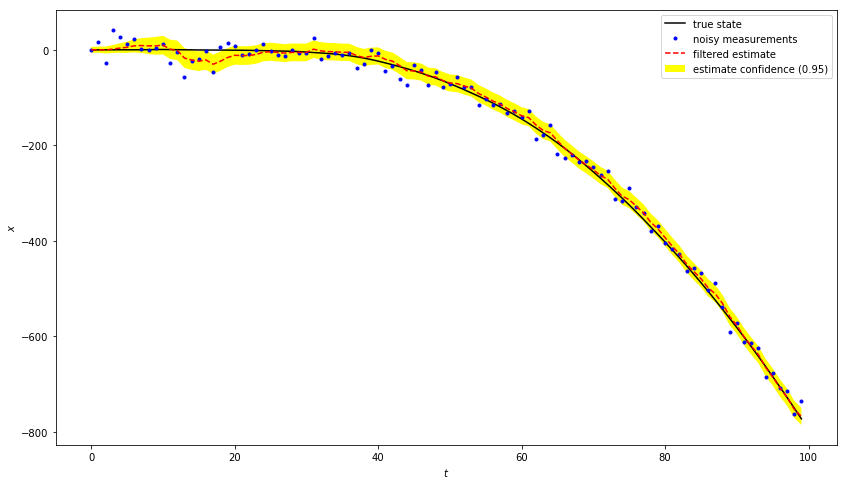

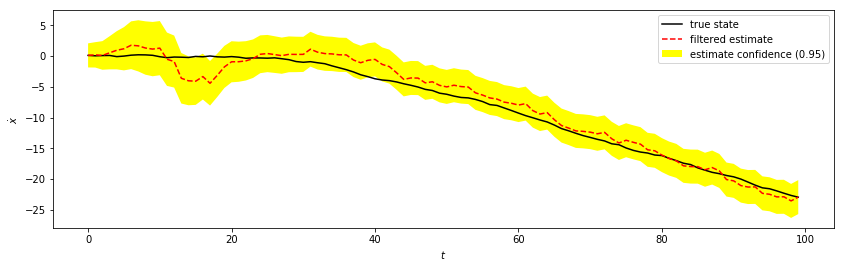

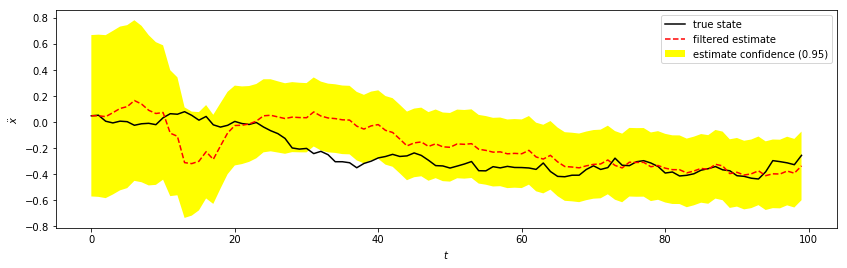

In [6]:
plt.figure(figsize=(14, 8))

plt.plot(y_true.T, 'k-')
plt.plot(y_noisy.T, 'b.')
plt.plot(y_estimate.T, 'r--')

err = 1.96*np.sqrt(P_estimate[0,0,:].reshape(y_estimate.shape))

ymax = y_estimate.ravel() + err.ravel()
ymin = y_estimate.ravel() - err.ravel()

plt.fill_between(np.arange(100),ymax,ymin, facecolor='yellow', interpolate=True)

plt.xlabel('$t$')
plt.ylabel('$x$')
plt.legend(labels=['true state','noisy measurements','filtered estimate','estimate confidence (0.95)'])


lbl = ['$\dot{x}$','$\ddot{x}$']
for i in range(2):
    plt.figure(figsize=(14,4))
    plt.plot(x_true[i+1,:].ravel(),'k-')
    plt.plot(x_estimate[i+1,:].ravel(), 'r--')
    
    err = 1.96*np.sqrt(P_estimate[i+1,i+1,:].ravel())
    xmax = x_estimate[i+1,:].ravel() + err.ravel()
    xmin = x_estimate[i+1,:].ravel() - err.ravel()

    plt.fill_between(np.arange(100), xmax, xmin, facecolor='yellow', interpolate=True)
    plt.xlabel('$t$')
    plt.ylabel(lbl[i])
    plt.legend(labels=['true state','filtered estimate','estimate confidence (0.95)'])

In [7]:
rts = KalmanSmoother.from_filter(kf)
states = rts.smooth()

x_smoothed = np.zeros_like(x_true)
P_smoothed = np.zeros((n_x, n_x, n_t))
y_smoothed = np.zeros_like(y_true)

x_smoothed[:,0] = x0.ravel()
y_smoothed[:,0] = (H @ x0).ravel()
P_smoothed[:,:,0] = P0

for i_ in range(1, n_t):
    x_smoothed[:,i_] = states[i_]['expected'].ravel()
    P_smoothed[:,:,i_] = states[i_]['err_cov']
    y_smoothed[:,i_] = (H @ x_smoothed[:,i_].reshape(n_x,1)).ravel()

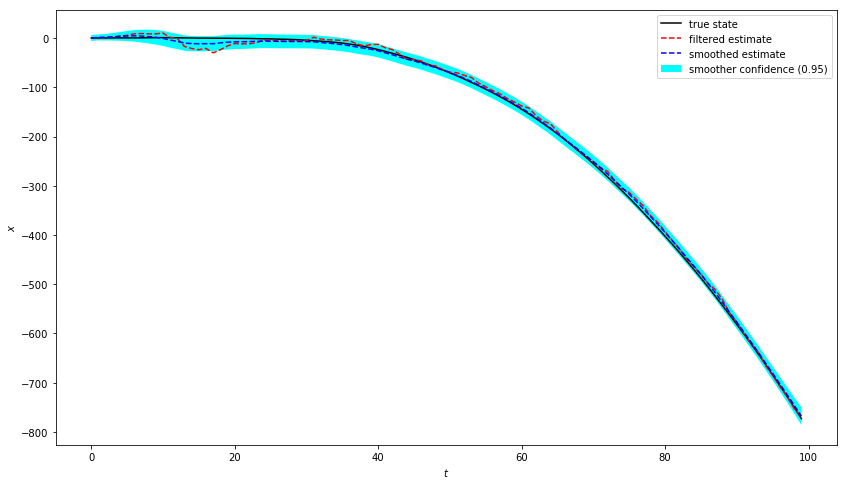

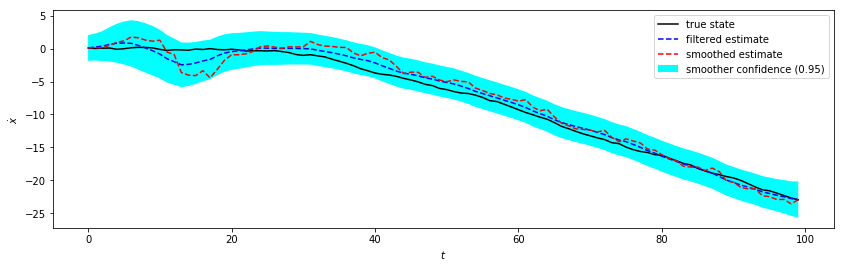

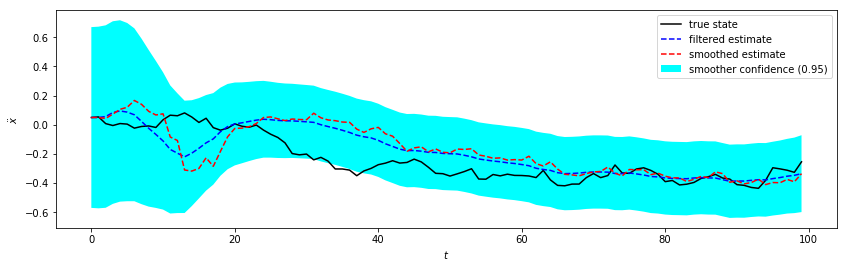

In [8]:
plt.figure(figsize=(14, 8))

plt.plot(y_true.T, 'k-')
plt.plot(y_estimate.T, 'r--')
plt.plot(y_smoothed.T, 'b--')

err = 1.96*np.sqrt(P_smoothed[0,0,:].reshape(y_smoothed.shape))

ymax = y_smoothed.ravel() + err.ravel()
ymin = y_smoothed.ravel() - err.ravel()

plt.fill_between(np.arange(100), ymax, ymin, facecolor='cyan', interpolate=True)

plt.xlabel('$t$')
plt.ylabel('$x$')
plt.legend(labels=['true state','filtered estimate','smoothed estimate','smoother confidence (0.95)'])

lbl = ['$\dot{x}$','$\ddot{x}$']
for i in range(2):
    plt.figure(figsize=(14,4))
    plt.plot(x_true[i+1,:].ravel(),'k-')
    plt.plot(x_smoothed[i+1,:].ravel(), 'b--')
    plt.plot(x_estimate[i+1,:].ravel(), 'r--')
    
    err = 1.96*np.sqrt(P_smoothed[i+1,i+1,:].ravel())
    xmax = x_smoothed[i+1,:].ravel() + err.ravel()
    xmin = x_smoothed[i+1,:].ravel() - err.ravel()

    plt.fill_between(np.arange(100), xmax, xmin, facecolor='cyan', interpolate=True)
    
    plt.xlabel('$t$')
    plt.ylabel(lbl[i])
    plt.legend(labels=['true state','filtered estimate','smoothed estimate','smoother confidence (0.95)'])

In [9]:
pr = KalmanFilter(x0, P0, F, Q, H, R, _verbose=False)

n_s = int(np.fix(0.8*n_t))

x_predict = np.zeros((n_x, n_t-n_s))
P_predict = np.zeros((n_x, n_x, n_t-n_s))
y_predict = np.zeros((n_y, n_t-n_s))

for i_ in range(1, n_s):#%n_t):
    pr.predict()
    pr.update(y_noisy[:,i_])
    
for i_ in range(0,n_t-n_s):
    pr.predict()
    x_predict[:,i_]   = pr.state['expected'].ravel()
    P_predict[:,:,i_] = pr.state['err_cov']
    y_predict[:,i_] = (H @ x_predict[:,i_].reshape(n_x,1)).ravel()
    

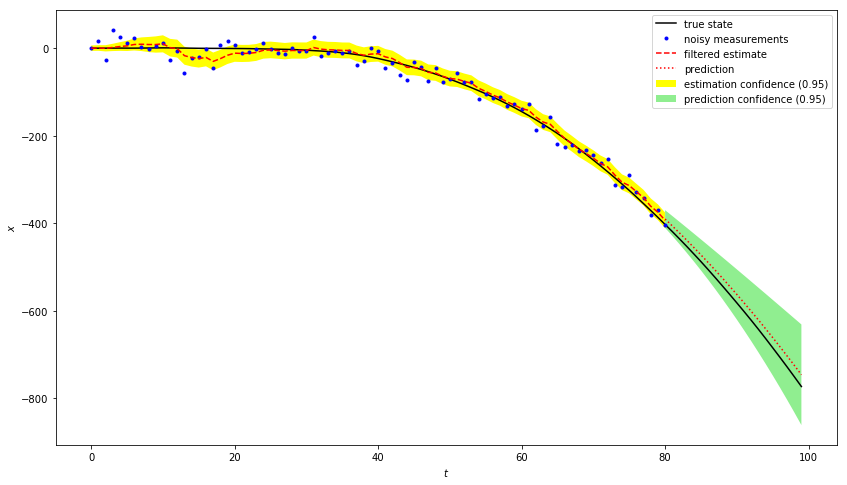

In [10]:
plt.figure(figsize=(14, 8))

plt.plot(y_true.T, 'k-')
plt.plot(y_noisy[:,0:n_s+1].T, 'b.')
plt.plot(y_estimate[:,0:n_s+1].T, 'r--')

plt.plot(np.arange(n_s,n_t),y_predict.ravel(),'r:')

err = 1.96*np.sqrt(P_estimate[0,0,0:n_s+1].reshape(n_y,n_s+1))

ymax = y_estimate[:,0:n_s+1].ravel() + err.ravel()
ymin = y_estimate[:,0:n_s+1].ravel() - err.ravel()

plt.fill_between(np.arange(n_s+1),ymax,ymin, facecolor='yellow', interpolate=True)

err = 1.96*np.sqrt(P_predict[0,0,:].reshape(y_predict.shape))

ymax = y_predict.ravel() + err.ravel()
ymin = y_predict.ravel() - err.ravel()

plt.fill_between(np.arange(n_s,n_t),ymax,ymin, facecolor='lightgreen', interpolate=True)

plt.xlabel('$t$')
plt.ylabel('$x$')
plt.legend(labels=['true state', 'noisy measurements', 'filtered estimate','prediction','estimation confidence (0.95)','prediction confidence (0.95)'])